# NeRF
## Part 1: Fit a Neural Field to a 2D Image

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm
import numpy as np
import random
import imageio
import cv2
import os
import time

from torchvision.transforms.functional import to_pil_image
from IPython.display import HTML

!pip install mediapy einops --quiet
!pip install viser --quiet
import viser

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.8/704.8 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.1/112.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, L: int):
        super().__init__()
        self.L = L

    def forward(self, coordinates):
        positional_encoding_features = []

        for i in range(self.L):
            positional_encoding_features.append(torch.sin(2**i * torch.pi * coordinates))
            positional_encoding_features.append(torch.cos(2**i * torch.pi * coordinates))

        positional_encoding_features = torch.cat(positional_encoding_features, dim=-1)
        positional_encoded_coordinates = torch.cat((coordinates, positional_encoding_features), dim=-1)
        return positional_encoded_coordinates

In [4]:
class NeuralFieldMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers, L):
        super().__init__()
        self.num_hidden_layers = num_hidden_layers

        self.SPE = SinusoidalPositionalEncoding(L)

        self.linear_input = nn.Linear(input_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.linear_output = nn.Linear(hidden_dim, output_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.SPE(x)
        x = self.linear_input(x)
        x = self.relu(x)
        for _ in range(self.num_hidden_layers):
            x = self.linear(x)
            x = self.relu(x)
        x = self.linear_output(x)
        x = self.sigmoid(x)
        return x

In [5]:
image = imageio.imread("animal.jpg")
image_height, image_width = image.shape[0], image.shape[1]

# Prepare coordinate grid and stack with color channels
x_grid = np.tile(np.arange(image_width), (image_height, 1))
y_grid = np.tile(np.arange(image_height).reshape(-1, 1), (1, image_width))
processed_data = np.stack((x_grid, y_grid, image[:, :, 0], image[:, :, 1], image[:, :, 2]), axis=0)
processed_data = processed_data.transpose(1, 2, 0).reshape(-1, 5)
processed_data = torch.tensor(processed_data, dtype=torch.float32).to(device)

# Hyperparameters
L = 10
input_dimension = 4 * L + 2
output_dimension = 3
number_of_hidden_layers = 4
learning_rate = 1e-2
hidden_dimension = 256
number_of_epochs = 10
batch_size = 10000

# Model and data setup
model = NeuralFieldMLP(input_dimension, hidden_dimension, output_dimension, number_of_hidden_layers, L).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

coordinates_data = processed_data[:, :2]
color_values = processed_data[:, 2:]
training_dataset = torch.utils.data.TensorDataset(coordinates_data, color_values)
training_data_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

# Training process
model.train()
psnr_values = []
epsilon = 1e-8

for epoch_index in range(number_of_epochs):
    for coordinate_batch, color_batch in training_data_loader:
        # Normalize coordinates and color values
        x_normalized = coordinate_batch[:, 0] / image_width
        y_normalized = coordinate_batch[:, 1] / image_height
        normalized_coordinates = torch.stack((x_normalized, y_normalized), dim=-1)
        normalized_colors = color_batch / 255.0

        normalized_coordinates = normalized_coordinates.to(device)
        normalized_colors = normalized_colors.to(device)

        # Forward pass
        predicted_colors = model(normalized_coordinates)
        loss = loss_function(predicted_colors, normalized_colors)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log PSNR
        psnr = 10 * torch.log10(1 / (loss + epsilon))
        psnr_values.append(psnr.item())

    # Epoch logging
    print(f"Epoch {epoch_index + 1}/{number_of_epochs}, Loss: {loss.item()}")

<ipython-input-5-8802608f4327>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread("animal.jpg")


KeyboardInterrupt: 

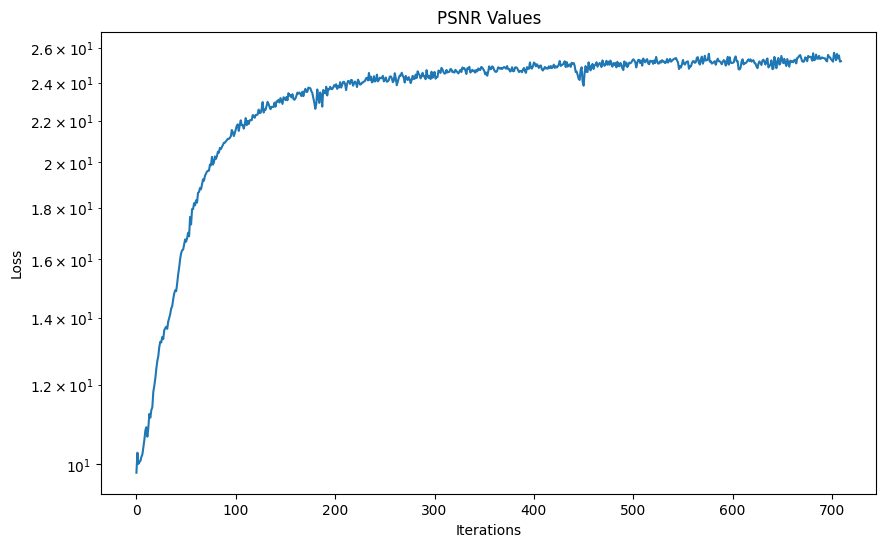

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(psnr_values)), psnr_values)
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('PSNR Values')
plt.show()

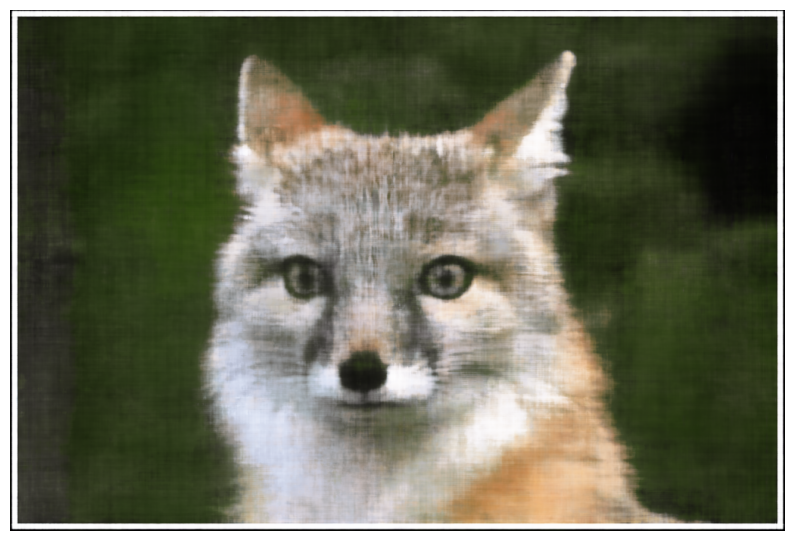

In [33]:
model.eval()
mse_loss = nn.MSELoss()

all_coordinates = []
all_predictions = []

with torch.no_grad():
    for coordinate_batch, _ in training_data_loader:
        coordinate_batch = coordinate_batch.to(device)
        x = coordinate_batch[:, 0]
        y = coordinate_batch[:, 1]

        x_normalized = x / image_width
        y_normalized = y / image_height

        normalized_coordinates = torch.stack((x_normalized, y_normalized), dim=-1)

        predicted_colors = model(normalized_coordinates)

        all_coordinates.append(coordinate_batch.cpu())
        all_predictions.append(predicted_colors.cpu())

all_coordinates = torch.vstack(all_coordinates)
all_predictions = torch.vstack(all_predictions)

# Rescale predictions back to 0 to 255
all_predictions *= 255.0
all_predictions = all_predictions.clamp(0, 255).byte()

# Reconstruct image by mapping predictions back to their respective pixel locations
reconstructed_image = torch.zeros((image_height, image_width, 3), dtype=torch.uint8)
for coordinate, rgb_value in zip(all_coordinates, all_predictions):
    x_pixel = max(0, min(int(coordinate[0].item()), image_width - 1))
    y_pixel = max(0, min(int(coordinate[1].item()), image_height - 1))
    reconstructed_image[y_pixel, x_pixel] = rgb_value

reconstructed_image = to_pil_image(reconstructed_image.permute(2, 0, 1))

plt.figure(figsize=(10, 10))
plt.imshow(reconstructed_image)
plt.axis('off')
plt.show()

## Part 2: Fit a Neural Radiance Field from Multi-view Images

In [5]:
data = np.load(f"lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images:
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering:
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = float(data["focal"])  # float

### Part 2.1: Create Rays from Cameras

In [6]:
def transform(c2w, x_c):
    if x_c.ndim == 1:
        x_c = x_c.unsqueeze(0)

    x_homogeneous = torch.cat([x_c, torch.ones_like(x_c[..., :1])], dim=-1)

    # Handle batched or single matrix input
    x_transformed = (
        torch.einsum('bij,bj->bi', c2w, x_homogeneous)
        if c2w.ndim == 3
        else torch.matmul(x_homogeneous, c2w.T)
    )

    result = x_transformed[..., :3]
    return result.squeeze(0) if x_c.ndim == 1 else result

In [7]:
def pixel_to_camera(K, uv, s):
    if uv.ndim == 1:
        uv = uv.unsqueeze(0)

    # Ensure homogeneous coordinates and scale are on the same device as uv
    uv_homogeneous = torch.cat([uv, torch.ones_like(uv[..., :1], device=uv.device)], dim=-1)
    scaled_coordinates = s.unsqueeze(-1).to(uv.device) * uv_homogeneous

    K_inverse = torch.inverse(K.to(uv.device))

    # Handle batched or single matrix input
    if K.ndim == 3:
        camera_coordinates = torch.bmm(K_inverse, scaled_coordinates.unsqueeze(-1)).squeeze(-1)
    else:
        camera_coordinates = torch.matmul(scaled_coordinates, K_inverse.T)

    return camera_coordinates.squeeze(0) if uv.ndim == 1 else camera_coordinates

In [8]:
def pixel_to_ray(K, c2w, uv):
    if uv.ndim == 1:
        uv = uv.unsqueeze(0)
    if c2w.ndim == 2:
        c2w = c2w.unsqueeze(0)

    # Origin of ray in world coordinates
    ray_origin_camera = torch.zeros((c2w.shape[0], 3), dtype=torch.float32, device=c2w.device)
    ray_origin_world = transform(c2w, ray_origin_camera)

    scaling_factor = torch.ones((uv.shape[0],), dtype=torch.float32, device=uv.device)
    coords_camera = pixel_to_camera(K, uv, scaling_factor)
    coords_world = transform(c2w, coords_camera)

    ray_direction_world = coords_world - ray_origin_world
    ray_direction_world = ray_direction_world / torch.norm(ray_direction_world, dim=-1, keepdim=True)

    return ray_origin_world, ray_direction_world

## Part 2.2: Sampling

In [9]:
def ray_to_points(ray_origins, ray_directions, perturbation, n_samples=32, near=2.0, far=6.0):
    t_values = torch.linspace(near, far, n_samples, device=ray_origins.device)
    step_size = (far - near) / n_samples

    if perturbation:
        t_values += torch.rand(len(t_values), device=ray_origins.device) * step_size

    # Reshape for broadcasting with ray origins and directions
    t_values = t_values.view(1, n_samples, 1)
    ray_origins = ray_origins[:, None, :]
    ray_directions = ray_directions[:, None, :]
    points = ray_origins + t_values * ray_directions

    return points

In [10]:
def create_intrinsics_matrix(focal_length, width=200, height=200):
    # Create the camera intrinsics matrix
    intrinsics = torch.tensor(
        [[focal_length, 0, width / 2],
         [0, focal_length, height / 2],
         [0, 0, 1]],
        dtype=torch.float32
    )
    return intrinsics

In [11]:
K = create_intrinsics_matrix(float(focal))

In [12]:
class RaysData(nn.Module):
    def __init__(self, images_train: torch.Tensor, intrinsics: torch.Tensor, poses_train: torch.Tensor):
        super().__init__()
        self.images_train = torch.tensor(images_train, dtype=torch.float32)
        self.intrinsics = intrinsics
        self.poses_train = torch.tensor(poses_train, dtype=torch.float32)

        self.image_height = images_train.shape[1]
        self.image_width = images_train.shape[2]

        h_coords = torch.arange(self.image_height)
        w_coords = torch.arange(self.image_width)
        self.uvs = torch.stack(torch.meshgrid(w_coords, h_coords, indexing='xy'), dim=-1).reshape(-1, 2).long()

    def to(self, device):
        self.images_train = self.images_train.to(device)
        self.intrinsics = self.intrinsics.to(device)
        self.poses_train = self.poses_train.to(device)
        self.uvs = self.uvs.to(device)
        return self

    def sample_rays(self, num_samples: int):
        device = self.poses_train.device

        num_images, height, width, _ = self.images_train.shape
        image_indices = torch.randint(0, num_images, (num_samples,), device=device)

        u_coords = torch.randint(0, width, (num_samples,), device=device, dtype=torch.float32) + 0.5
        v_coords = torch.randint(0, height, (num_samples,), device=device, dtype=torch.float32) + 0.5
        sampled_uvs = torch.stack([u_coords, v_coords], dim=-1)

        selected_poses = self.poses_train[image_indices]

        # Compute ray origins and directions
        ray_origins, ray_directions = pixel_to_ray(self.intrinsics, selected_poses, sampled_uvs)

        return ray_origins, ray_directions, sampled_uvs, image_indices

## Part 2.3: Putting the Dataloading All Together

In [13]:
import viser, time  # pip install viser
import numpy as np

# --- You Need to Implement These ------
dataset = RaysData(images_train, K, c2ws_train)
rays_o, rays_d, pixels, image_indices = dataset.sample_rays(100) # Should expect (B, 3)
points = ray_to_points(rays_o, rays_d, perturbation=True)
H, W = images_train.shape[1:3]

rays_o_np = rays_o.detach().cpu().numpy()
rays_d_np = rays_d.detach().cpu().numpy()
points_np = points.detach().cpu().numpy()
K_np = K.detach().cpu().numpy()

# ---------------------------------------

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
    server.add_camera_frustum(
        f"/cameras/{i}",
        fov=2 * np.arctan2(H / 2, K_np[0, 0]),
        aspect=W / H,
        scale=0.15,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=image
    )
for i, (o, d) in enumerate(zip(rays_o_np, rays_d_np)):
    server.add_spline_catmull_rom(
        f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
    )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points_np).reshape(-1, 3),
    points=points_np.reshape(-1, 3),
    point_size=0.02,
)
time.sleep(1000)

╭──────────────── viser ────────────────╮
│             ╷                         │
│   HTTP      │ http://localhost:8081   │
│   Websocket │ ws://localhost:8081     │
│             ╵                         │
╰───────────────────────────────────────╯

(viser) Share URL requested!

(viser) Generated share URL (expires in 24 hours, max 32 clients): https://polygon-discrete.share.viser.studio

<ipython-input-13-01f2b60a8841>:19: DeprecationWarning: ViserServer.add_camera_frustum has been deprecated, use ViserServer.scene.add_camera_frustum instead. Alternatively, pin to `viser<0.2.0`.
  server.add_camera_frustum(
<ipython-input-13-01f2b60a8841>:29: DeprecationWarning: ViserServer.add_spline_catmull_rom has been deprecated, use ViserServer.scene.add_spline_catmull_rom instead. Alternatively, pin to `viser<0.2.0`.
  server.add_spline_catmull_rom(
<ipython-input-13-01f2b60a8841>:32: DeprecationWarning: ViserServer.add_point_cloud has been deprecated, use ViserServer.scene.add_point_cloud instead. Alternatively, pin to `viser<0.2.0`.
  server.add_point_cloud(


(viser) Disconnected from share URL

ERROR:websockets.server:opening handshake failed
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/websockets/http11.py", line 134, in parse
    request_line = yield from parse_line(read_line)
  File "/usr/local/lib/python3.10/dist-packages/websockets/http11.py", line 380, in parse_line
    line = yield from read_line(MAX_LINE_LENGTH)
  File "/usr/local/lib/python3.10/dist-packages/websockets/streams.py", line 46, in read_line
    raise EOFError(f"stream ends after {p} bytes, before end of line")
EOFError: stream ends after 0 bytes, before end of line

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/websockets/asyncio/server.py", line 353, in conn_handler
    await connection.handshake(
  File "/usr/local/lib/python3.10/dist-packages/websockets/asyncio/server.py", line 204, in handshake
    raise self.protocol.handshake_exc
  File "/usr/local/lib/pyt

KeyboardInterrupt: 

Run this code to verify that the rays are positioned where they are supposed to be positioned.

In [ ]:
# Visualize Cameras, Rays and Samples
import viser, time
import numpy as np

# --- You Need to Implement These ------
dataset = RaysData(images_train, K, c2ws_train)

# This will check that your uvs aren't flipped
uvs_start = 0
uvs_end = 40_000
sample_uvs = dataset.uvs[uvs_start:uvs_end] # These are integer coordinates of widths / heights (xy not yx) of all the pixels in an image
# uvs are array of xy coordinates, so we need to index into the 0th image tensor with [0, height, width], so we need to index with uv[:,1] and then uv[:,0]
#assert np.all(images_train[0, sample_uvs[:,1], sample_uvs[:,0]] == dataset.pixels[uvs_start:uvs_end])

# # Uncoment this to display random rays from the first image
#indices = np.random.randint(low=0, high=40_000, size=100)

# # Uncomment this to display random rays from the top left corner of the image
indices_x = np.random.randint(low=0, high=100, size=100)
indices_y = np.random.randint(low=0, high=100, size=100)
indices = indices_x + (indices_y*200)

data = {"rays_o": dataset.rays_o[indices], "rays_d": dataset.rays_d[indices]}
points = ray_to_points(data["rays_o"], data["rays_d"], perturbation=True)

rays_o_np = rays_o.detach().cpu().numpy()
rays_d_np = rays_d.detach().cpu().numpy()
points_np = points.detach().cpu().numpy()
K_np = K.detach().cpu().numpy()
# ---------------------------------------

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
  server.add_camera_frustum(
    f"/cameras/{i}",
    fov=2 * np.arctan2(H / 2, K_np[0, 0]),
    aspect=W / H,
    scale=0.15,
    wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
    position=c2w[:3, 3],
    image=image
  )
for i, (o, d) in enumerate(zip(data["rays_o"], data["rays_d"])):
  positions = np.stack((o, o + d * 6.0))
  server.add_spline_catmull_rom(
      f"/rays/{i}", positions=positions,
  )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points_np).reshape(-1, 3),
    points=points_np.reshape(-1, 3),
    point_size=0.03,
)
time.sleep(1000)

## Part 2.4

In [15]:
class NeuralFieldMLP3D(nn.Module):
    def __init__(self, input_dim, hidden_dim, rgb_output_dim, density_output_dim, num_hidden_layers, L_x, L_r_d):
        super().__init__()
        self.num_hidden_layers = num_hidden_layers
        self.SPE_x = SinusoidalPositionalEncoding(L_x)
        self.SPE_r_d = SinusoidalPositionalEncoding(L_r_d)

        self.input_layer = nn.Linear(input_dim, hidden_dim)

        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()

        self.linear_after_concat = nn.Linear(hidden_dim + 6 * L_x + 3, hidden_dim)

        self.linear_density = nn.Linear(hidden_dim, density_output_dim)

        self.linear_scaledown = nn.Linear(hidden_dim + 6 * L_r_d + 3, hidden_dim // 2)
        self.linear_rgb = nn.Linear(hidden_dim // 2, rgb_output_dim)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x, r_d):
        positional_encoded = self.SPE_x(x)
        current = self.input_layer(positional_encoded)
        current = self.relu(current)
        current = self.linear(current)
        current = self.relu(current)
        current = self.linear(current)
        current = self.relu(current)
        current = self.linear(current)
        current = self.relu(current)

        current = torch.cat([current, positional_encoded], dim=-1)

        current = self.linear_after_concat(current)
        current = self.relu(current)

        for _ in range(self.num_hidden_layers - 1):
            current = self.linear(current)
            current = self.relu(current)

        current = self.linear(current)

        density = self.linear_density(current)
        density = self.relu(density)

        current = self.linear(current)

        r_d = self.SPE_r_d(r_d)

        current = torch.cat([current, r_d], dim=-1)

        scaledown = self.linear_scaledown(current)
        scaledown = self.relu(scaledown)
        rgb = self.linear_rgb(scaledown)
        rgb = self.sigmoid(rgb)

        return rgb, density

## Part 2.5

## Bells and Whistles - Background Color

In [21]:
def volrend(sigmas, rgbs, step_size, near_black_threshold=0.0108):
    alphas = 1.0 - torch.exp(-sigmas * step_size)
    transmittance = torch.cumprod(1.0 - alphas + 1e-10, dim=1)
    transmittance = torch.cat([torch.ones_like(transmittance[:, :1, :]), transmittance[:, :-1, :]], dim=1)

    weights = alphas * transmittance
    rendered_colors = torch.sum(weights * rgbs, dim=1)

    # Post-process: Replace near-black pixels with blue
    background_color = torch.tensor([173 / 255, 216 / 255, 230 / 255], dtype=torch.float32).to(rendered_colors.device)
    is_black = rendered_colors.norm(dim=-1) < near_black_threshold
    rendered_colors[is_black] = background_color

    return rendered_colors

In [17]:
def test_model(model, K, c2w_test, width, height, n_samples):
    model.eval()
    step_size = (6.0 - 2.0) / n_samples

    # Generate pixel coordinates
    w_coordinates = torch.arange(width, device=c2w_test.device)
    h_coordinates = torch.arange(height, device=c2w_test.device)
    pixel_coordinates = torch.stack(torch.meshgrid(w_coordinates, h_coordinates, indexing="xy"), dim=-1).reshape(-1, 2).float()

    rays_origin, rays_direction = pixel_to_ray(K, c2w_test, pixel_coordinates)

    sample_points = ray_to_points(rays_origin, rays_direction, perturbation=False, n_samples=n_samples)
    rays_direction_expanded = rays_direction.unsqueeze(1).expand(-1, sample_points.shape[1], -1)

    flat_points = sample_points.reshape(-1, 3)
    flat_directions = rays_direction_expanded.reshape(-1, 3)

    # Predict colors and densities for points along the rays
    with torch.no_grad():
        predicted_colors, predicted_densities = model(flat_points, flat_directions)

    predicted_colors = predicted_colors.view(height * width, n_samples, 3)
    predicted_densities = predicted_densities.view(height * width, n_samples, 1)

    reconstructed_image = volrend(predicted_densities, predicted_colors, step_size)

    output_image = reconstructed_image.view(height, width, 3)

    return output_image

In [18]:
def validate_model(model, images_val, K, c2ws_validation, width, height, n_samples):
    model.eval()
    step_size = (6.0 - 2.0) / n_samples
    total_psnr = 0

    for i in range(10):
        camera_pose = torch.tensor(c2ws_validation[i], dtype=torch.float32).to(device)
        validation_image = images_val[i]

        # Generate pixel coordinates
        w_coordinates = torch.arange(width, device=camera_pose.device)
        h_coordinates = torch.arange(height, device=camera_pose.device)
        pixel_coordinates = torch.stack(torch.meshgrid(w_coordinates, h_coordinates, indexing="xy"), dim=-1).reshape(-1, 2).float()

        ray_origins, ray_directions = pixel_to_ray(K, camera_pose, pixel_coordinates)

        sample_points = ray_to_points(ray_origins, ray_directions, perturbation=False, n_samples=n_samples)
        ray_directions_expanded = ray_directions.unsqueeze(1).expand(-1, sample_points.shape[1], -1)

        flat_points = sample_points.reshape(-1, 3)
        flat_directions = ray_directions_expanded.reshape(-1, 3)

        # Predict colors and densities for points along the rays
        with torch.no_grad():
            predicted_colors, predicted_densities = model(flat_points, flat_directions)

        predicted_colors = predicted_colors.view(height * width, n_samples, 3)
        predicted_densities = predicted_densities.view(height * width, n_samples, 1)

        reconstructed_image = volrend(predicted_densities, predicted_colors, step_size)

        output_image = reconstructed_image.view(height, width, 3)

        epsilon = 1e-8
        mse = torch.mean((output_image - validation_image) ** 2)
        psnr = -10.0 * torch.log10(mse + epsilon)
        total_psnr += psnr.item()

    average_psnr = total_psnr / 10
    return average_psnr

In [22]:
def train_model(model, training_dataset, optimizer, criterion, device, epochs, batch_size, n_samples, testing=False):
    num_images, image_height, image_width, _ = training_dataset.images_train.shape
    num_points = num_images * image_height * image_width
    model.train()

    training_loss_history = []
    validation_loss_history = []
    validation_iterations = []

    num_iterations = num_points // batch_size
    print("Number of iterations: ", num_iterations)
    for epoch in range(epochs):
        for batch in tqdm(range(num_iterations)):
            ray_origins, ray_directions, pixel_coordinates, image_indices = training_dataset.sample_rays(batch_size)
            sample_points = ray_to_points(ray_origins, ray_directions, perturbation=True, n_samples=n_samples)

            # Generate ray directions for all sampled points and correct pixel coordinates
            ray_directions_expanded = ray_directions.unsqueeze(1).repeat(1, sample_points.shape[1], 1)
            corrected_pixel_coordinates = pixel_coordinates - 0.5
            pixel_coordinates_int = corrected_pixel_coordinates.long()

            ground_truth_colors = training_dataset.images_train[
                image_indices, pixel_coordinates_int[:, 1], pixel_coordinates_int[:, 0], :
            ]

            flat_points = sample_points.view(-1, 3)
            flat_directions = ray_directions_expanded.view(-1, 3)

            # Predict colors and densities, compute loss, and optimize model weights
            predicted_colors, predicted_densities = model(flat_points, flat_directions)
            predicted_colors = predicted_colors.view(batch_size, n_samples, 3)
            predicted_densities = predicted_densities.view(batch_size, n_samples, 1)

            step_size = (6.0 - 2.0) / n_samples
            reconstructed_image_colors = volrend(predicted_densities, predicted_colors, step_size)
            loss = criterion(reconstructed_image_colors, ground_truth_colors)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epsilon = 1e-8
            psnr_loss = 10 * torch.log10(1 / (loss + epsilon))
            training_loss_history.append(psnr_loss.item())

            if testing and (batch + 1) % 1000 == 0:
                psnr_val = validate_model(
                    model, images_val, K, c2ws_val, width=200, height=200, n_samples=64
                )
                validation_loss_history.append(psnr_val)
                validation_iterations.append(epoch * (num_points // batch_size) + batch)

                test_pose = torch.tensor(c2ws_train[0], dtype=torch.float32).to(device)
                with torch.no_grad():
                    test_image = test_model(model, K, test_pose, width=200, height=200, n_samples=n_samples)

                test_image = (test_image.cpu().numpy() * 255).astype(np.uint8)
                plt.figure(figsize=(6, 6))
                plt.imshow(test_image)
                plt.title(f"Render at Epoch {epoch} (batch {batch + 1})")
                plt.axis("off")
                plt.show()

    return training_loss_history, validation_loss_history, validation_iterations

<ipython-input-12-5c1e32d4c202>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.poses_train = torch.tensor(poses_train, dtype=torch.float32)


Number of iterations:  2000


 50%|████▉     | 999/2000 [02:03<02:02,  8.15it/s]<ipython-input-18-f17e574fe9b4>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  camera_pose = torch.tensor(c2ws_validation[i], dtype=torch.float32).to(device)
<ipython-input-22-88386de036f0>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_pose = torch.tensor(c2ws_train[0], dtype=torch.float32).to(device)


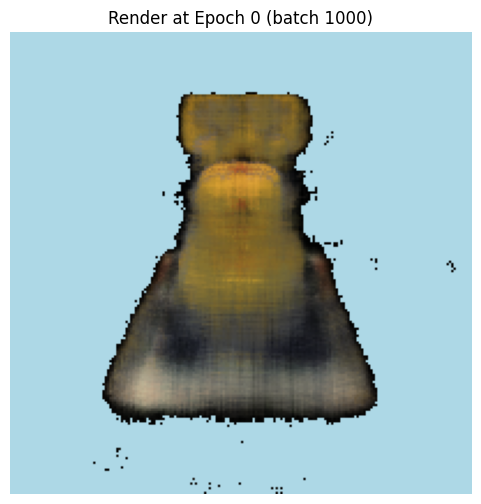

100%|█████████▉| 1999/2000 [04:27<00:00,  8.24it/s]

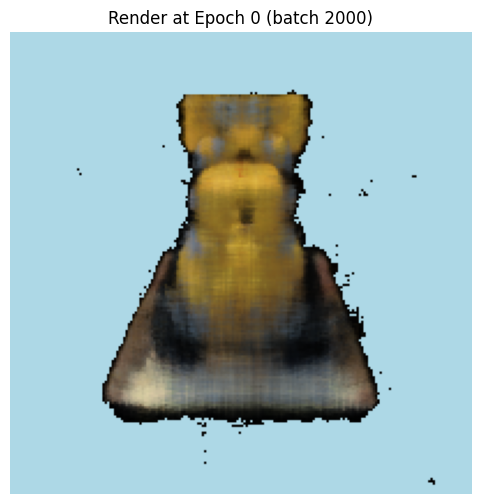

100%|██████████| 2000/2000 [04:49<00:00,  6.91it/s]


In [23]:
data = np.load(f"lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images:
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering:
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = float(data["focal"])  # float

device = torch.device("cuda")
c2ws_val = torch.tensor(c2ws_val, dtype=torch.float32).to(device)
c2ws_train = torch.tensor(c2ws_train, dtype=torch.float32).to(device)
K = K = create_intrinsics_matrix(float(focal)).to(device)
images_val = torch.tensor(images_val, dtype=torch.float32).to(device)

L_x = 10
L_r_d = 4
input_dim = 6* L_x +3
hidden_dim = 256
rgb_output_dim = 3
density_output_dim = 1
num_hidden_layers = 8
model = NeuralFieldMLP3D(input_dim, hidden_dim, rgb_output_dim, density_output_dim, num_hidden_layers, L_x, L_r_d).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

training_dataset = RaysData(images_train, K, c2ws_train).to(device)

loss_history_training, loss_history_val, validation_iterations = train_model(
    model=model,
    training_dataset=training_dataset,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epochs=1,
    batch_size=2000,
    n_samples = 32,
    testing = True
)

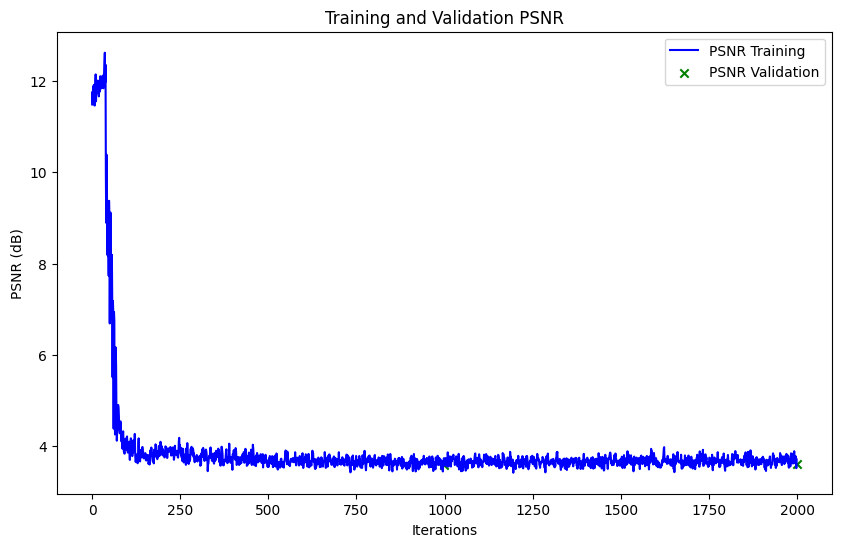

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(loss_history_training)), loss_history_training, label='PSNR Training', color='blue')
plt.scatter(validation_iterations, loss_history_val, color='green', label='PSNR Validation', marker='x')

plt.xlabel('Iterations')
plt.ylabel('PSNR (dB)')
plt.title('Training and Validation PSNR')
plt.legend()
plt.show()

In [25]:
c2ws_val = torch.tensor(c2ws_val, dtype=torch.float32).to(device)
images_val = torch.tensor(images_val, dtype=torch.float32).to(device)

PSNR_val = validate_model(model ,images_val, K.to(device), c2ws_val, width=200, height=200, n_samples = 64)
print(PSNR_val)

<ipython-input-25-725d3de31bf2>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c2ws_val = torch.tensor(c2ws_val, dtype=torch.float32).to(device)
<ipython-input-25-725d3de31bf2>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_val = torch.tensor(images_val, dtype=torch.float32).to(device)
<ipython-input-18-f17e574fe9b4>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  camera_pose = torch.tensor(c2ws_validation[i], dtype=torch.float32).to(device)


KeyboardInterrupt: 

## Testing on test set

In [26]:
for i in range(60):
    c2w_test = torch.tensor(c2ws_test[i], dtype=torch.float32).to(device)

    with torch.no_grad():
        test_image = test_model(model, K.to(device), c2w_test, width=200, height=200, n_samples = 64)

    frame = (test_image.cpu().numpy() * 255).astype(np.uint8)
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f"frame_{i:03d}.png", frame_bgr)

video_filename = "nerf_render.mp4"
fps = 30

# Initialize VideoWriter
video_writer = cv2.VideoWriter(
    video_filename,
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (200, 200)
)

for i in range(60):
    frame_path = f"frame_{i:03d}.png"
    frame = cv2.imread(frame_path)
    video_writer.write(frame)

video_writer.release()
print(f"Saved {video_filename}")

# create a gif and download
gif_filename = "nerf_render.gif"
gif_path = os.path.join(os.getcwd(), gif_filename)
os.system(f"convert -delay 10 -loop 0 frame_*.png {gif_path}")
os.system(f"rm -f frame_*.png")
print(f"Saved {gif_filename}")


Saved nerf_render.mp4
Saved nerf_render.gif


In [ ]:
from google.colab import files

files.download(video_filename)

### Deprecated

In [ ]:
def transform2(c2w, x_c):
    if x_c.ndim == 1:
        x_c = x_c.unsqueeze(0)
    x_c_homog = torch.cat([x_c, torch.ones_like(x_c[..., :1])], dim=-1)

    #Is it correct to transpose c2w here?
    x_w_homog = torch.matmul(x_c_homog, c2w.transpose(0, 1))
    x_w = x_w_homog[..., :3]

    return x_w.squeeze(0) if x_c.ndim == 1 else x_w



In [ ]:
def pixel_to_camera2(K, uv, s):
    if uv.ndim == 1:
        uv = uv.unsqueeze(0)

    uv_homog = torch.cat([uv, torch.ones_like(uv[..., :1])], dim=-1)
    scaled_uv = s.unsqueeze(-1) * uv_homog
    K_inv = torch.inverse(K)
    x_c = torch.matmul(scaled_uv, K_inv.T)
    return x_c.squeeze(0) if uv.ndim == 1 else x_c

In [ ]:
def pixel_to_ray2(K, c2w, uv):
    r_o_cam = torch.tensor([0.0, 0.0, 0.0], dtype=torch.float32)
    r_o_world = transform(c2w, r_o_cam)

    s = 1
    s = torch.tensor(s, dtype=torch.float32)
    x_c = pixel_to_camera(K, uv, s)
    x_w = transform(c2w, x_c)

    r_d_world = x_w - r_o_world
    r_d_world = r_d_world / torch.norm(r_d_world, dim=-1, keepdim=True)

    return r_o_world, r_d_world


In [ ]:
def sample_rays_from_images(images, Ks, c2ws, N, M):
    sampled_rays = []
    num_images, height, width, _ = images.shape
    rays_per_image = N // M
    for i in range (M):
      image_num = torch.randint(0, num_images, (1,)).item()
      selected_image = images[image_num]
      selected_c2w = c2ws[image_num]
      selected_K = Ks[image_num]

      u = torch.randint(0, width, (rays_per_image,), dtype=torch.float32) + 0.5
      v = torch.randint(0, height, (rays_per_image,), dtype=torch.float32) + 0.5
      uv = torch.stack([u, v], dim=-1)
      ray_o, ray_d = pixel_to_ray(selected_K, selected_c2w, uv)

      sampled_rays.append((ray_o, ray_d))

    return sampled_rays

In [ ]:
def sample_rays_globally(images, Ks, c2ws, N):
    num_images, height, width, _ = images.shape

    image_indices = torch.randint(0, num_images, (N,))
    u = torch.randint(0, width, (N,), dtype=torch.float32) + 0.5
    v = torch.randint(0, height, (N,), dtype=torch.float32) + 0.5
    uv = torch.stack([u, v], dim=-1)

    ray_origins = []
    ray_directions = []
    for i in range(num_images):
        mask = image_indices == i
        selected_uv = uv[mask]
        selected_K = Ks[i]
        selected_c2w = c2ws[i]

        ray_o, ray_d = pixel_to_ray(selected_K, selected_c2w, selected_uv)
        ray_origins.append(ray_o)
        ray_directions.append(ray_d)

    ray_origins = torch.cat(ray_origins, dim=0)
    ray_directions = torch.cat(ray_directions, dim=0)

    return ray_origins, ray_directions


In [ ]:
        self.rays_o = torch.zeros((self.height*self.width, 3), dtype=torch.float32)
        self.rays_d = torch.zeros((self.height*self.width, 3), dtype=torch.float32)
        self.pixels = torch.zeros((self.height*self.width, 2), dtype=torch.float32)

        c2w = self.c2ws_train[0]
        K = self.K

        for i in range (self.height*self.width):
          uv = self.uvs[i]
          ray_o, ray_d = pixel_to_ray(K, c2w, uv)
          self.rays_o[i] = ray_o
          self.rays_d[i] = ray_d
          self.pixels[i] = uv

In [ ]:
class RaysData2(nn.Module):
    def __init__(
        self,
        images_train: torch.Tensor,
        K: torch.Tensor,
        c2ws_train: torch.Tensor,
    ):
        self.images_train = torch.tensor(images_train, dtype=torch.float32)
        self.K = K
        self.c2ws_train = torch.tensor(c2ws_train, dtype=torch.float32)

        self.height = images_train.shape[1]
        self.width = images_train.shape[2]

        h = torch.arange(self.height)
        w = torch.arange(self.width)
        self.uvs = torch.stack(torch.meshgrid(w, h, indexing='xy'), dim=-1).reshape(-1, 2).long()



    def sample_rays(self, N: int):
      num_images, height, width, _ = self.images_train.shape

      image_indices = torch.randint(0, num_images, (N,))

      rays_o = torch.zeros((N, 3), dtype=torch.float32)
      rays_d = torch.zeros((N, 3), dtype=torch.float32)
      pixels = torch.zeros((N, 2), dtype=torch.float32)

      for i in range(N):
        image_idx = image_indices[i]
        selected_c2w = self.c2ws_train[image_idx]
        selected_K = self.K
        u = torch.randint(0, width, (1,), dtype=torch.float32) + 0.5
        v = torch.randint(0, height, (1,), dtype=torch.float32) + 0.5
        uv = torch.stack([u, v], dim=-1)

        ray_o, ray_d = pixel_to_ray(selected_K, selected_c2w, uv)

        rays_o[i] = ray_o
        rays_d[i] = ray_d
        pixels[i] = uv

      return rays_o, rays_d, pixels

